## Prepare Environment

In [ ]:
# !pip install -q torchprofile 1>/dev/null
!pip install -q torch-summary

In [ ]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List
from tqdm import tqdm
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Prepare Dataset

In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/My Drive/resnet18_trashdetection/Garbage Classifier.v27i.coco.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/data')

### COCO dataset class

In [ ]:
import torch
from torch.utils.data import Dataset
from pycocotools.coco import COCO
import os
import cv2
import torchvision.transforms as T

class COCODatasetClassification(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        """
        image_dir: path to images
        annotation_file: path to COCO annotations
        transform: transforms to apply
        """
        self.image_dir = image_dir
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())
        self.transform = transform
        self.image_ids = [img_id for img_id in self.coco.imgs.keys()
                  if len(self.coco.getAnnIds(imgIds=img_id)) > 0]


    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(image_id)[0]
        img_path = os.path.join(self.image_dir, img_info['file_name'])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get all annotations for this image
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)

        # Pick the first annotation's category_id
        label = anns[0]['category_id']

        if self.transform:
          image = self.transform(image)


        return image, label


def get_transform(train=True):
    if train:
        return T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224)),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])
    else:
        return T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])


In [ ]:
train_dataset = COCODatasetClassification(
    image_dir='/content/data/train',
    annotation_file='/content/data/train/_annotations.coco.json',
    transform=get_transform(train=True)
)

val_dataset = COCODatasetClassification(
    image_dir='/content/data/valid',
    annotation_file='/content/data/valid/_annotations.coco.json',
    transform=get_transform(train=False)
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
for image, targets in train_loader:
    # Process images and targets
    print("Shape", image.shape)
    print("targets", targets)
    break

Shape torch.Size([32, 3, 224, 224])
targets tensor([3, 6, 4, 5, 2, 3, 1, 1, 3, 5, 3, 4, 4, 1, 4, 4, 3, 4, 5, 5, 6, 3, 3, 7,
        3, 3, 6, 3, 3, 5, 3, 4])


In [ ]:
image_datasets = {
    'train': train_dataset,
    'val': val_dataset,
}

Number of classes: 8


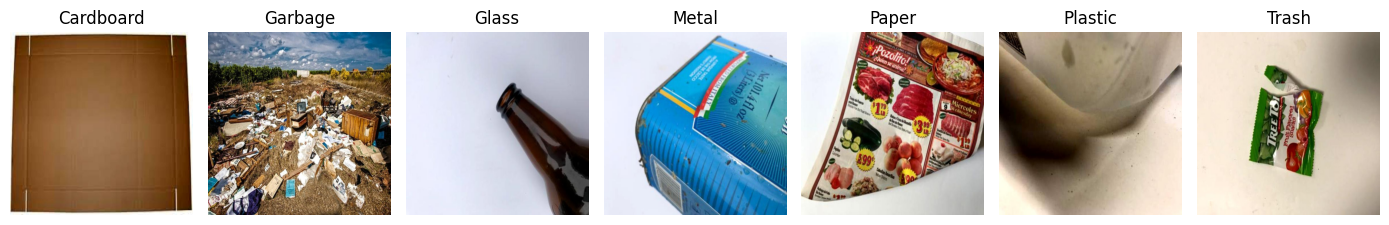

In [ ]:
import matplotlib.pyplot as plt
import os

# Get class names and IDs
class_names = image_datasets['train'].coco.cats
class_ids = list(class_names.keys())
print(f"Number of classes: {len(class_ids)}")

# Limit number of classes to display
num_classes_to_try = min(20, len(class_ids))  # Try up to 20 classes
images_to_display = []

# Gather valid images and labels
for class_id in class_ids:
    class_name = class_names[class_id]['name']
    image_index = next(
        (index for index, ann in enumerate(image_datasets['train'].coco.anns.values())
         if ann['category_id'] == class_id),
        None
    )

    if image_index is not None:
        image_id = image_datasets['train'].image_ids[image_index]  # Use image_ids from the dataset
        image_info = image_datasets['train'].coco.loadImgs(image_id)[0]
        image_path = os.path.join(image_datasets['train'].image_dir, image_info['file_name'])  # Use image_dir

        if os.path.exists(image_path):
            images_to_display.append((image_path, class_name))

    if len(images_to_display) >= num_classes_to_try:
        break

# Plot only the collected valid images
fig, ax = plt.subplots(1, len(images_to_display), figsize=(2 * len(images_to_display), 5))

# Handle single subplot case
if len(images_to_display) == 1:
    ax = [ax]

for i, (img_path, label) in enumerate(images_to_display):
    image = plt.imread(img_path)
    ax[i].imshow(image)
    ax[i].set_title(label)
    ax[i].axis('off')

plt.tight_layout()
plt.show()


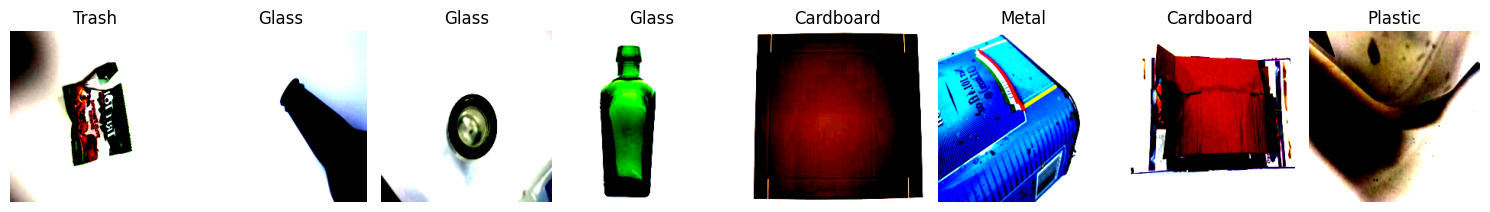

In [ ]:
import matplotlib.pyplot as plt

def show_images(dataset, class_names, num_images=5):
    """
    dataset: your dataset object
    class_names: list of class names (id -> name mapping)
    num_images: number of images to show
    """

    plt.figure(figsize=(15, 5))  # width x height

    for idx in range(num_images):
        image, label = dataset[idx]
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # CHW -> HWC if needed

        plt.subplot(1, num_images, idx + 1)
        plt.imshow(image)
        plt.title(class_names[label], fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
# After you load your dataset
class_names = [
    "Garbage",  # id=0
    "Cardboard",  # id=1
    "Garbage",  # id=2
    "Glass",  # id=3
    "Metal",  # id=4
    "Paper",  # id=5
    "Plastic",  # id=6
    "Trash"  # id=7
]

show_images(train_dataset, class_names, num_images=len(class_names))


### Push dataset to HF

In [ ]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import os
from datasets import Dataset, DatasetDict, Image
class_names = [
    "Garbage",  # id=0
    "Cardboard",  # id=1
    "Garbage",  # id=2
    "Glass",  # id=3
    "Metal",  # id=4
    "Paper",  # id=5
    "Plastic",  # id=6
    "Trash"  # id=7
]

def coco_to_hf(coco_dataset, split):
    image_paths = []
    labels = []
    class_names_list = []  # List to store class names
    bboxes = []  # List to store bounding boxes
    segmentations = [] # list to store segmentations
    image_dir = coco_dataset.image_dir  # Access the image_dir attribute

    for image_id in coco_dataset.image_ids:  # Iterate through image_ids
        img_info = coco_dataset.coco.loadImgs(image_id)[0]
        img_path = os.path.join(image_dir, img_info['file_name'])
        image_paths.append(img_path)

        ann_ids = coco_dataset.coco.getAnnIds(imgIds=image_id)
        anns = coco_dataset.coco.loadAnns(ann_ids)
        label = anns[0]['category_id']
        labels.append(label)
        class_names_list.append(class_names[label])  # Append class name

        # Extract and append bounding boxes for the current image
        bboxes.append([ann['bbox'] for ann in anns])

        #Extract and append segmentations for the current image
        segmentations.append([ann['segmentation'] for ann in anns])

    dataset = Dataset.from_dict({
        "image": image_paths,
        "label": labels,
        "class_name": class_names_list,  # Use the list of class names
        "bbox": bboxes,  # Use the list of bounding boxes
        "segmentation": segmentations # Use the list of segmentations
    }).cast_column("image", Image())

    return dataset

# Assuming train_dataset and val_dataset are instances of COCODatasetClassification
train_hf_dataset = coco_to_hf(train_dataset, "train")
val_hf_dataset = coco_to_hf(val_dataset, "validation")

dataset = DatasetDict({
    "train": train_hf_dataset,
    "validation": val_hf_dataset
})
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'class_name', 'bbox', 'segmentation'],
        num_rows: 3094
    })
    validation: Dataset({
        features: ['image', 'label', 'class_name', 'bbox', 'segmentation'],
        num_rows: 397
    })
})

In [ ]:
dataset.push_to_hub("dmedhi/garbage-image-classification-detection")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/3094 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/31 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/397 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/dmedhi/garbage-image-classification-detection/commit/a4e1cfa4634e9c37509f4af9866e6955d3912ba2', commit_message='Upload dataset', commit_description='', oid='a4e1cfa4634e9c37509f4af9866e6955d3912ba2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/dmedhi/garbage-image-classification-detection', endpoint='https://huggingface.co', repo_type='dataset', repo_id='dmedhi/garbage-image-classification-detection'), pr_revision=None, pr_num=None)

## Model

In [ ]:
import torch
import torch.nn as nn
from collections import OrderedDict, defaultdict


class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.block = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)),
            ('bn1', nn.BatchNorm2d(out_channels)),
            ('relu1', nn.ReLU(inplace=True)),
            ('conv2', nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)),
            ('bn2', nn.BatchNorm2d(out_channels)),
        ]))
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.block(x)

        if self.downsample:
            identity = self.downsample(x)

        out += identity
        return self.relu(out)


class ResNet18(nn.Module):
    BLOCK_CONFIG = [2, 2, 2, 2]  # Number of blocks per layer group

    def __init__(self):
        super().__init__()

        layers = []
        counts = defaultdict(int)

        def add(name: str, layer: nn.Module) -> None:
            layers.append((f"{name}{counts[name]}", layer))
            counts[name] += 1

        in_channels = 64
        # Initial conv + bn + relu + pool
        add("conv", nn.Conv2d(3, in_channels, kernel_size=7, stride=2, padding=3, bias=False))
        add("bn", nn.BatchNorm2d(in_channels))
        add("relu", nn.ReLU(inplace=True))
        add("pool", nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        self.stem = nn.Sequential(OrderedDict(layers))

        self.in_channels = in_channels
        self.layer1 = self._make_layer(64,  self.BLOCK_CONFIG[0], stride=1)
        self.layer2 = self._make_layer(128, self.BLOCK_CONFIG[1], stride=2)
        self.layer3 = self._make_layer(256, self.BLOCK_CONFIG[2], stride=2)
        self.layer4 = self._make_layer(512, self.BLOCK_CONFIG[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(512, 10)

    def _make_layer(self, out_channels, blocks, stride):
        layers = []
        downsample = None

        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers.append(BasicBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels

        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input: [N, 3, 224, 224]
        x = self.stem(x)           # -> [N, 64, 56, 56]
        x = self.layer1(x)         # -> [N, 64, 56, 56]
        x = self.layer2(x)         # -> [N, 128, 28, 28]
        x = self.layer3(x)         # -> [N, 256, 14, 14]
        x = self.layer4(x)         # -> [N, 512, 7, 7]
        x = self.avgpool(x)        # -> [N, 512, 1, 1]
        x = torch.flatten(x, 1)    # -> [N, 512]
        x = self.classifier(x)     # -> [N, 10]
        return x
model = ResNet18()

### From torchvision

In [ ]:
from torchvision import models, transforms
import torch.nn as nn
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 8)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
%%timeit
evaluate(model, val_loader)

[INFO] Evaluation - Accuracy: 5.54%


[INFO] Evaluation - Accuracy: 5.54%


[INFO] Evaluation - Accuracy: 5.54%


[INFO] Evaluation - Accuracy: 5.54%


[INFO] Evaluation - Accuracy: 5.54%


[INFO] Evaluation - Accuracy: 5.54%


[INFO] Evaluation - Accuracy: 5.54%


[INFO] Evaluation - Accuracy: 5.54%
2.52 s ± 415 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
model

ResNet18(
  (stem): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (block): Sequential(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (block): Sequential(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [ ]:
from torchsummary import summary
import torch

dummy_input = torch.randn(1, 3, 32, 32)
summary(model, dummy_input, depth=2)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 16, 16]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 16, 16]          128
├─ReLU: 1-3                              [-1, 64, 16, 16]          --
├─MaxPool2d: 1-4                         [-1, 64, 8, 8]            --
├─Sequential: 1-5                        [-1, 64, 8, 8]            --
|    └─BasicBlock: 2-1                   [-1, 64, 8, 8]            73,984
|    └─BasicBlock: 2-2                   [-1, 64, 8, 8]            73,984
├─Sequential: 1-6                        [-1, 128, 4, 4]           --
|    └─BasicBlock: 2-3                   [-1, 128, 4, 4]           230,144
|    └─BasicBlock: 2-4                   [-1, 128, 4, 4]           295,424
├─Sequential: 1-7                        [-1, 256, 2, 2]           --
|    └─BasicBlock: 2-5                   [-1, 256, 2, 2]           919,040
|    └─BasicBlock: 2-6                   [-1, 256, 2, 2]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 16, 16]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 16, 16]          128
├─ReLU: 1-3                              [-1, 64, 16, 16]          --
├─MaxPool2d: 1-4                         [-1, 64, 8, 8]            --
├─Sequential: 1-5                        [-1, 64, 8, 8]            --
|    └─BasicBlock: 2-1                   [-1, 64, 8, 8]            73,984
|    └─BasicBlock: 2-2                   [-1, 64, 8, 8]            73,984
├─Sequential: 1-6                        [-1, 128, 4, 4]           --
|    └─BasicBlock: 2-3                   [-1, 128, 4, 4]           230,144
|    └─BasicBlock: 2-4                   [-1, 128, 4, 4]           295,424
├─Sequential: 1-7                        [-1, 256, 2, 2]           --
|    └─BasicBlock: 2-5                   [-1, 256, 2, 2]           919,040
|    └─BasicBlock: 2-6                   [-1, 256, 2, 2]  

In [ ]:
def get_model(num_classes: int = 8):
    return ResNet18(num_classes=num_classes)

def get_model_macs(model, inputs) -> int:
    """
    calcualte profile macs
    """
    model = model.cuda()
    model.eval()
    inputs = inputs.cuda()
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

## Training & Evaluation

In [ ]:
import torch
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt

def calculate_accuracy(outputs: torch.Tensor, targets: torch.Tensor) -> float:
    predictions = torch.argmax(outputs, dim=1)
    correct_predictions = (predictions == targets).sum().item()
    total_samples = targets.size(0)
    accuracy = (correct_predictions / total_samples) * 100
    return accuracy
def train(
    model: nn.Module,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    scheduler: LambdaLR,
    num_epochs: int = 50,
    patience: int = 10,  # Number of epochs to wait for improvement
    save_path: str = "/content/drive/My Drive/resnet18_trashdetection/best_model_checkpoint.pth",
    callbacks=None
) -> tuple[list, list, list, list]:
    model = model.cuda()

    best_accuracy = 0.0  # To track the best validation accuracy
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    epochs_without_improvement = 0  # Track the number of epochs without improvement

    for epoch in range(num_epochs):
        model.train()

        running_loss = 0.0
        running_accuracy = 0.0
        total_samples = 0

        # Training Phase
        for inputs, targets in tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False):
            inputs = inputs.cuda()
            targets = targets.cuda()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Metrics
            batch_accuracy = calculate_accuracy(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            running_accuracy += batch_accuracy * inputs.size(0)
            total_samples += inputs.size(0)

            if callbacks is not None:
                for callback in callbacks:
                    callback()

        epoch_loss = running_loss / total_samples
        epoch_accuracy = running_accuracy / total_samples

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Validation Phase
        model.eval()  # Switch model to evaluation mode
        val_loss = 0.0
        val_accuracy = 0.0
        total_samples = 0
        num_correct = 0

        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs = inputs.cuda()
                targets = targets.cuda()

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                batch_accuracy = calculate_accuracy(outputs, targets)

                val_loss += loss.item() * inputs.size(0)
                val_accuracy += batch_accuracy * inputs.size(0)
                total_samples += inputs.size(0)

        val_loss /= total_samples
        val_accuracy /= total_samples
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"[INFO] Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_accuracy:.2f}% | Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")

        # Early stopping: Check if validation accuracy improved
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            epochs_without_improvement = 0  # Reset counter if there is improvement
            # Save the best model along with the optimizer, scheduler, and epoch information
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_accuracy': best_accuracy,
            }
            torch.save(checkpoint, save_path)
            print(f"[INFO] Checkpoint saved at epoch {epoch+1} with validation accuracy: {val_accuracy:.2f}%")
        else:
            epochs_without_improvement += 1

        # Stop training if no improvement for `patience` epochs
        if epochs_without_improvement >= patience:
            print(f"[INFO] Early stopping triggered. No improvement for {patience} epochs.")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies


def evaluate(model: nn.Module, dataloader: DataLoader, criterion: nn.Module = None, verbose=True) -> float:
    model = model.cuda()
    model.eval()

    num_samples = 0
    num_correct = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Evaluating", leave=False, disable=not verbose):
            inputs = inputs.cuda()
            targets = targets.cuda()

            outputs = model(inputs)
            predictions = outputs.argmax(dim=1)

            num_samples += targets.size(0)
            num_correct += (predictions == targets).sum().item()

            if criterion:
                loss = criterion(outputs, targets)
                running_loss += loss.item() * inputs.size(0)

    accuracy = (num_correct / num_samples) * 100
    avg_loss = (running_loss / num_samples) if criterion else None

    if verbose:
        if avg_loss is not None:
            print(f"[INFO] Evaluation - Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")
        else:
            print(f"[INFO] Evaluation - Accuracy: {accuracy:.2f}%")

    return accuracy

def plot_training_chart(train_losses: list, train_accuracies: list, val_losses: list, val_accuracies: list):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'g-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'orange', label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


### Before training

In [ ]:
print(f"Before training...")
# model = get_model()
dense_model_accuracy = evaluate(model, val_loader)
dense_model_size = get_model_size(model)
print(f"[INFO] Accuracy before training ={dense_model_accuracy:.4f}%")
print(f"[INFO] Model size ={dense_model_size/MiB:.4f} MiB")

Before training...


[INFO] Evaluation - Accuracy: 5.54%
[INFO] Accuracy before training =5.5416%
[INFO] Model size =42.6507 MiB


### Model Training

In [ ]:
import torch.optim as optim

# model = get_model()

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
total_steps = len(train_loader) # Steps per epoch (for simplicity, let's decay per epoch step count)
scheduler = LambdaLR(optimizer, lr_lambda=lambda step: 1 - step / total_steps if step <= total_steps else 0)
num_epochs = 100
patience=20

save_path = "/content/drive/My Drive/resnet18_trashdetection/best_model_checkpoint_torchvision_resnet18.pth"
train_losses, train_accuracies, val_losses, val_accuracies = train(
    model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    save_path=save_path,
    patience=patience
)

[INFO] Epoch 1/100 | Train Loss: 1.6756 | Train Accuracy: 42.21% | Validation Loss: 1.5087 | Validation Accuracy: 49.87%
[INFO] Checkpoint saved at epoch 1 with validation accuracy: 49.87%


[INFO] Epoch 2/100 | Train Loss: 1.4939 | Train Accuracy: 49.22% | Validation Loss: 1.5028 | Validation Accuracy: 51.64%
[INFO] Checkpoint saved at epoch 2 with validation accuracy: 51.64%


[INFO] Epoch 3/100 | Train Loss: 1.4965 | Train Accuracy: 48.97% | Validation Loss: 1.5015 | Validation Accuracy: 51.39%


[INFO] Epoch 4/100 | Train Loss: 1.5056 | Train Accuracy: 48.80% | Validation Loss: 1.5027 | Validation Accuracy: 51.39%


[INFO] Epoch 5/100 | Train Loss: 1.4993 | Train Accuracy: 48.71% | Validation Loss: 1.5012 | Validation Accuracy: 51.39%


[INFO] Epoch 6/100 | Train Loss: 1.4967 | Train Accuracy: 48.45% | Validation Loss: 1.5037 | Validation Accuracy: 51.64%


[INFO] Epoch 7/100 | Train Loss: 1.5019 | Train Accuracy: 48.80% | Validation Loss: 1.5058 | Validation Accuracy: 52.14%
[INFO] Checkpoint saved at epoch 7 with validation accuracy: 52.14%


[INFO] Epoch 8/100 | Train Loss: 1.4971 | Train Accuracy: 50.19% | Validation Loss: 1.5017 | Validation Accuracy: 53.15%
[INFO] Checkpoint saved at epoch 8 with validation accuracy: 53.15%


[INFO] Epoch 9/100 | Train Loss: 1.5039 | Train Accuracy: 48.55% | Validation Loss: 1.4995 | Validation Accuracy: 51.89%


[INFO] Epoch 10/100 | Train Loss: 1.4924 | Train Accuracy: 49.71% | Validation Loss: 1.4992 | Validation Accuracy: 52.14%


[INFO] Epoch 11/100 | Train Loss: 1.5018 | Train Accuracy: 48.93% | Validation Loss: 1.4996 | Validation Accuracy: 51.89%


[INFO] Epoch 12/100 | Train Loss: 1.4992 | Train Accuracy: 49.32% | Validation Loss: 1.5042 | Validation Accuracy: 52.90%


[INFO] Epoch 13/100 | Train Loss: 1.4992 | Train Accuracy: 48.74% | Validation Loss: 1.4990 | Validation Accuracy: 52.14%


[INFO] Epoch 14/100 | Train Loss: 1.4943 | Train Accuracy: 49.32% | Validation Loss: 1.4995 | Validation Accuracy: 52.64%


[INFO] Epoch 15/100 | Train Loss: 1.4946 | Train Accuracy: 49.55% | Validation Loss: 1.5083 | Validation Accuracy: 50.38%


[INFO] Epoch 16/100 | Train Loss: 1.4879 | Train Accuracy: 50.45% | Validation Loss: 1.5057 | Validation Accuracy: 50.88%


[INFO] Epoch 17/100 | Train Loss: 1.4944 | Train Accuracy: 48.64% | Validation Loss: 1.5054 | Validation Accuracy: 50.88%


[INFO] Epoch 18/100 | Train Loss: 1.4958 | Train Accuracy: 49.29% | Validation Loss: 1.5128 | Validation Accuracy: 49.37%


[INFO] Epoch 19/100 | Train Loss: 1.4962 | Train Accuracy: 49.45% | Validation Loss: 1.4994 | Validation Accuracy: 52.64%


[INFO] Epoch 20/100 | Train Loss: 1.4913 | Train Accuracy: 49.45% | Validation Loss: 1.5078 | Validation Accuracy: 51.64%


[INFO] Epoch 21/100 | Train Loss: 1.4942 | Train Accuracy: 48.74% | Validation Loss: 1.4964 | Validation Accuracy: 52.90%


[INFO] Epoch 22/100 | Train Loss: 1.4960 | Train Accuracy: 49.39% | Validation Loss: 1.4960 | Validation Accuracy: 52.90%


[INFO] Epoch 23/100 | Train Loss: 1.4981 | Train Accuracy: 48.97% | Validation Loss: 1.5048 | Validation Accuracy: 50.63%


[INFO] Epoch 24/100 | Train Loss: 1.4986 | Train Accuracy: 49.42% | Validation Loss: 1.4990 | Validation Accuracy: 54.16%
[INFO] Checkpoint saved at epoch 24 with validation accuracy: 54.16%


[INFO] Epoch 25/100 | Train Loss: 1.4989 | Train Accuracy: 48.32% | Validation Loss: 1.4981 | Validation Accuracy: 53.15%


[INFO] Epoch 26/100 | Train Loss: 1.5009 | Train Accuracy: 49.10% | Validation Loss: 1.5144 | Validation Accuracy: 49.87%


[INFO] Epoch 27/100 | Train Loss: 1.4985 | Train Accuracy: 49.42% | Validation Loss: 1.5085 | Validation Accuracy: 50.88%


[INFO] Epoch 28/100 | Train Loss: 1.4902 | Train Accuracy: 48.97% | Validation Loss: 1.4986 | Validation Accuracy: 51.13%


[INFO] Epoch 29/100 | Train Loss: 1.4958 | Train Accuracy: 48.97% | Validation Loss: 1.4973 | Validation Accuracy: 53.40%


[INFO] Epoch 30/100 | Train Loss: 1.4918 | Train Accuracy: 49.03% | Validation Loss: 1.5018 | Validation Accuracy: 54.16%


[INFO] Epoch 31/100 | Train Loss: 1.4982 | Train Accuracy: 48.74% | Validation Loss: 1.4988 | Validation Accuracy: 52.64%


[INFO] Epoch 32/100 | Train Loss: 1.4897 | Train Accuracy: 49.64% | Validation Loss: 1.5062 | Validation Accuracy: 51.64%


[INFO] Epoch 33/100 | Train Loss: 1.4908 | Train Accuracy: 49.03% | Validation Loss: 1.5037 | Validation Accuracy: 50.38%


[INFO] Epoch 34/100 | Train Loss: 1.4983 | Train Accuracy: 49.64% | Validation Loss: 1.5036 | Validation Accuracy: 52.14%


[INFO] Epoch 35/100 | Train Loss: 1.4960 | Train Accuracy: 49.39% | Validation Loss: 1.4999 | Validation Accuracy: 51.39%


[INFO] Epoch 36/100 | Train Loss: 1.4979 | Train Accuracy: 49.39% | Validation Loss: 1.5018 | Validation Accuracy: 52.39%


[INFO] Epoch 37/100 | Train Loss: 1.4908 | Train Accuracy: 49.42% | Validation Loss: 1.5018 | Validation Accuracy: 52.90%


[INFO] Epoch 38/100 | Train Loss: 1.4937 | Train Accuracy: 49.00% | Validation Loss: 1.5054 | Validation Accuracy: 50.63%


[INFO] Epoch 39/100 | Train Loss: 1.4924 | Train Accuracy: 49.35% | Validation Loss: 1.5005 | Validation Accuracy: 52.14%


[INFO] Epoch 40/100 | Train Loss: 1.5013 | Train Accuracy: 49.13% | Validation Loss: 1.5154 | Validation Accuracy: 48.36%


[INFO] Epoch 41/100 | Train Loss: 1.4996 | Train Accuracy: 49.19% | Validation Loss: 1.5051 | Validation Accuracy: 51.13%


[INFO] Epoch 42/100 | Train Loss: 1.5007 | Train Accuracy: 48.71% | Validation Loss: 1.4995 | Validation Accuracy: 52.39%


[INFO] Epoch 43/100 | Train Loss: 1.4960 | Train Accuracy: 48.84% | Validation Loss: 1.5031 | Validation Accuracy: 53.65%


[INFO] Epoch 44/100 | Train Loss: 1.4984 | Train Accuracy: 49.90% | Validation Loss: 1.4960 | Validation Accuracy: 53.15%
[INFO] Early stopping triggered. No improvement for 20 epochs.


### Plot metrics

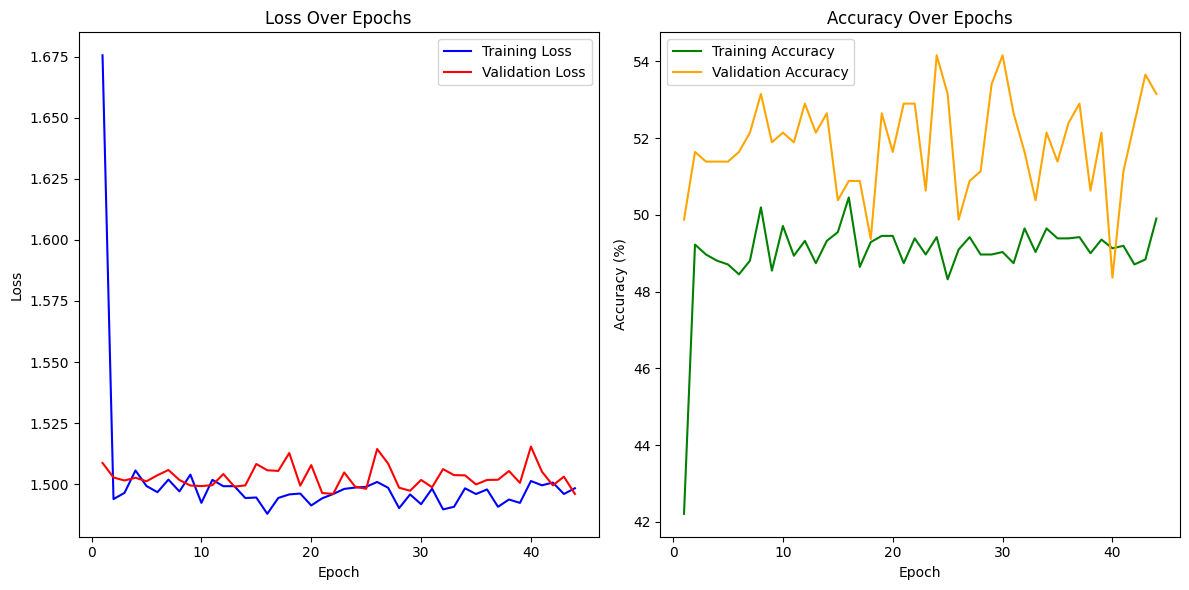

In [ ]:
plot_training_chart(train_losses, train_accuracies, val_losses, val_accuracies)

In [ ]:
save_path = "/content/drive/My Drive/resnet18_trashdetection/best_model_checkpoint_torchvision_resnet18.pth"
checkpoint = torch.load(save_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
epoch = checkpoint['epoch']
best_accuracy = checkpoint['best_accuracy']

In [ ]:
print(f"After training...")
dense_model_accuracy = evaluate(model, val_loader)
dense_model_size = get_model_size(model)
print(f"[INFO] Accuracy = {dense_model_accuracy:.4f}%")
print(f"[INFO] Model size = {dense_model_size/MiB:.4f} MiB")

After training...


[INFO] Evaluation - Accuracy: 54.16%
[INFO] Accuracy = 54.1562%
[INFO] Model size = 42.6507 MiB


## Inference

In [ ]:
from torchvision import transforms
import numpy as np
import cv2
# Inference on single image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def predict_image(model, image_path, transform, class_names):
    model.eval()

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = transform(image)
    # image = augmented['image']
    # image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
    image = image.unsqueeze(0).to(device)

    outputs = model(image)
    _, predicted = outputs.max(1)
    print(predicted)
    print(f"Predicted Class: {class_names[predicted.item()]}")
class_names = ["Garbage", "Cardboard", "Garbage", "Glass", "Metal", "Paper", "Plastic", "Trash"]

predict_image(model, '/content/data/valid/Plastic7_png.rf.73d0f3537012685e60c80c047a6df8d9.jpg', get_transform(train=False), class_names)


tensor([6], device='cuda:0')
Predicted Class: Plastic


## Pruning Model

### Fine-grained Pruning

In [ ]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()
    num_zeros = round(num_elements * sparsity)
    importance = torch.abs(tensor)
    threshold = torch.kthvalue(importance.flatten(), num_zeros)[0]
    mask = importance > threshold
    tensor.mul_(mask)

    return mask
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

### Sensitivity Scanning

In [ ]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

In [ ]:
sparsities, accuracies = sensitivity_scan(
    model, val_loader, scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 0/21 weight - conv1.weight:  17%|█▋        | 1/6 [00:02<00:13,  2.74s/it]

    sparsity=0.40: accuracy=45.09%

scanning 0/21 weight - conv1.weight:  33%|███▎      | 2/6 [00:05<00:10,  2.57s/it]

    sparsity=0.50: accuracy=29.22%

scanning 0/21 weight - conv1.weight:  50%|█████     | 3/6 [00:07<00:07,  2.53s/it]

    sparsity=0.60: accuracy=29.72%

scanning 0/21 weight - conv1.weight:  67%|██████▋   | 4/6 [00:10<00:04,  2.48s/it]

    sparsity=0.70: accuracy=25.44%

scanning 0/21 weight - conv1.weight:  83%|████████▎ | 5/6 [00:13<00:02,  2.87s/it]

    sparsity=0.80: accuracy=27.96%

scanning 0/21 weight - conv1.weight: 100%|██████████| 6/6 [00:16<00:00,  2.75s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[45.09%, 29.22%, 29.72%, 25.44%, 27.96%, 25.94%]

scanning 1/21 weight - layer1.0.conv1.weight:  17%|█▋        | 1/6 [00:02<00:11,  2.40s/it]

    sparsity=0.40: accuracy=51.89%

scanning 1/21 weight - layer1.0.conv1.weight:  33%|███▎      | 2/6 [00:04<00:09,  2.39s/it]

    sparsity=0.50: accuracy=52.39%

scanning 1/21 weight - layer1.0.conv1.weight:  50%|█████     | 3/6 [00:07<00:07,  2.37s/it]

    sparsity=0.60: accuracy=42.57%

scanning 1/21 weight - layer1.0.conv1.weight:  67%|██████▋   | 4/6 [00:10<00:05,  2.66s/it]

    sparsity=0.70: accuracy=36.52%

scanning 1/21 weight - layer1.0.conv1.weight:  83%|████████▎ | 5/6 [00:13<00:02,  2.93s/it]

    sparsity=0.80: accuracy=36.27%

scanning 1/21 weight - layer1.0.conv1.weight: 100%|██████████| 6/6 [00:16<00:00,  2.67s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[51.89%, 52.39%, 42.57%, 36.52%, 36.27%, 35.26%]

scanning 2/21 weight - layer1.0.conv2.weight:  17%|█▋        | 1/6 [00:02<00:12,  2.42s/it]

    sparsity=0.40: accuracy=51.39%

scanning 2/21 weight - layer1.0.conv2.weight:  33%|███▎      | 2/6 [00:04<00:09,  2.47s/it]

    sparsity=0.50: accuracy=52.90%

scanning 2/21 weight - layer1.0.conv2.weight:  50%|█████     | 3/6 [00:07<00:07,  2.56s/it]

    sparsity=0.60: accuracy=54.41%

scanning 2/21 weight - layer1.0.conv2.weight:  67%|██████▋   | 4/6 [00:12<00:06,  3.33s/it]

    sparsity=0.70: accuracy=50.38%

scanning 2/21 weight - layer1.0.conv2.weight:  83%|████████▎ | 5/6 [00:14<00:02,  2.98s/it]

    sparsity=0.80: accuracy=47.61%

scanning 2/21 weight - layer1.0.conv2.weight: 100%|██████████| 6/6 [00:16<00:00,  2.81s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[51.39%, 52.90%, 54.41%, 50.38%, 47.61%, 45.84%]

scanning 3/21 weight - layer1.1.conv1.weight:  17%|█▋        | 1/6 [00:02<00:13,  2.78s/it]

    sparsity=0.40: accuracy=52.64%

scanning 3/21 weight - layer1.1.conv1.weight:  33%|███▎      | 2/6 [00:05<00:11,  2.95s/it]

    sparsity=0.50: accuracy=52.39%

scanning 3/21 weight - layer1.1.conv1.weight:  50%|█████     | 3/6 [00:09<00:09,  3.13s/it]

    sparsity=0.60: accuracy=50.13%

scanning 3/21 weight - layer1.1.conv1.weight:  67%|██████▋   | 4/6 [00:11<00:05,  2.83s/it]

    sparsity=0.70: accuracy=47.36%

scanning 3/21 weight - layer1.1.conv1.weight:  83%|████████▎ | 5/6 [00:14<00:02,  2.69s/it]

    sparsity=0.80: accuracy=46.60%

scanning 3/21 weight - layer1.1.conv1.weight: 100%|██████████| 6/6 [00:16<00:00,  2.74s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[52.64%, 52.39%, 50.13%, 47.36%, 46.60%, 36.27%]

scanning 4/21 weight - layer1.1.conv2.weight:  17%|█▋        | 1/6 [00:02<00:13,  2.78s/it]

    sparsity=0.40: accuracy=53.15%

scanning 4/21 weight - layer1.1.conv2.weight:  33%|███▎      | 2/6 [00:06<00:13,  3.36s/it]

    sparsity=0.50: accuracy=52.39%

scanning 4/21 weight - layer1.1.conv2.weight:  50%|█████     | 3/6 [00:08<00:08,  2.93s/it]

    sparsity=0.60: accuracy=54.91%

scanning 4/21 weight - layer1.1.conv2.weight:  67%|██████▋   | 4/6 [00:11<00:05,  2.73s/it]

    sparsity=0.70: accuracy=52.14%

scanning 4/21 weight - layer1.1.conv2.weight:  83%|████████▎ | 5/6 [00:13<00:02,  2.62s/it]

    sparsity=0.80: accuracy=50.88%

scanning 4/21 weight - layer1.1.conv2.weight: 100%|██████████| 6/6 [00:16<00:00,  2.70s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[53.15%, 52.39%, 54.91%, 52.14%, 50.88%, 48.11%]

scanning 5/21 weight - layer2.0.conv1.weight:  17%|█▋        | 1/6 [00:03<00:19,  3.99s/it]

    sparsity=0.40: accuracy=53.90%

scanning 5/21 weight - layer2.0.conv1.weight:  33%|███▎      | 2/6 [00:06<00:12,  3.20s/it]

    sparsity=0.50: accuracy=52.39%

scanning 5/21 weight - layer2.0.conv1.weight:  50%|█████     | 3/6 [00:09<00:08,  2.87s/it]

    sparsity=0.60: accuracy=50.13%

scanning 5/21 weight - layer2.0.conv1.weight:  67%|██████▋   | 4/6 [00:12<00:05,  2.91s/it]

    sparsity=0.70: accuracy=48.36%

scanning 5/21 weight - layer2.0.conv1.weight:  83%|████████▎ | 5/6 [00:15<00:03,  3.02s/it]

    sparsity=0.80: accuracy=43.83%

scanning 5/21 weight - layer2.0.conv1.weight: 100%|██████████| 6/6 [00:19<00:00,  3.19s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[53.90%, 52.39%, 50.13%, 48.36%, 43.83%, 36.02%]

scanning 6/21 weight - layer2.0.conv2.weight:  17%|█▋        | 1/6 [00:03<00:17,  3.46s/it]

    sparsity=0.40: accuracy=52.90%

scanning 6/21 weight - layer2.0.conv2.weight:  33%|███▎      | 2/6 [00:05<00:11,  2.81s/it]

    sparsity=0.50: accuracy=52.14%

scanning 6/21 weight - layer2.0.conv2.weight:  50%|█████     | 3/6 [00:08<00:07,  2.64s/it]

    sparsity=0.60: accuracy=53.40%

scanning 6/21 weight - layer2.0.conv2.weight:  67%|██████▋   | 4/6 [00:11<00:05,  2.79s/it]

    sparsity=0.70: accuracy=53.15%

scanning 6/21 weight - layer2.0.conv2.weight:  83%|████████▎ | 5/6 [00:14<00:03,  3.06s/it]

    sparsity=0.80: accuracy=52.64%

scanning 6/21 weight - layer2.0.conv2.weight: 100%|██████████| 6/6 [00:17<00:00,  2.87s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[52.90%, 52.14%, 53.40%, 53.15%, 52.64%, 50.38%]

scanning 7/21 weight - layer2.0.downsample.0.weight:  17%|█▋        | 1/6 [00:02<00:12,  2.40s/it]

    sparsity=0.40: accuracy=51.39%

scanning 7/21 weight - layer2.0.downsample.0.weight:  33%|███▎      | 2/6 [00:04<00:09,  2.42s/it]

    sparsity=0.50: accuracy=51.13%

scanning 7/21 weight - layer2.0.downsample.0.weight:  50%|█████     | 3/6 [00:07<00:07,  2.51s/it]

    sparsity=0.60: accuracy=51.89%

scanning 7/21 weight - layer2.0.downsample.0.weight:  67%|██████▋   | 4/6 [00:11<00:06,  3.07s/it]

    sparsity=0.70: accuracy=47.36%

scanning 7/21 weight - layer2.0.downsample.0.weight:  83%|████████▎ | 5/6 [00:13<00:02,  2.83s/it]

    sparsity=0.80: accuracy=48.11%

scanning 7/21 weight - layer2.0.downsample.0.weight: 100%|██████████| 6/6 [00:16<00:00,  2.69s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[51.39%, 51.13%, 51.89%, 47.36%, 48.11%, 49.62%]

scanning 8/21 weight - layer2.1.conv1.weight:  17%|█▋        | 1/6 [00:02<00:12,  2.41s/it]

    sparsity=0.40: accuracy=52.64%

scanning 8/21 weight - layer2.1.conv1.weight:  33%|███▎      | 2/6 [00:04<00:09,  2.40s/it]

    sparsity=0.50: accuracy=53.15%

scanning 8/21 weight - layer2.1.conv1.weight:  50%|█████     | 3/6 [00:08<00:09,  3.03s/it]

    sparsity=0.60: accuracy=53.65%

scanning 8/21 weight - layer2.1.conv1.weight:  67%|██████▋   | 4/6 [00:11<00:05,  2.91s/it]

    sparsity=0.70: accuracy=52.64%

scanning 8/21 weight - layer2.1.conv1.weight:  83%|████████▎ | 5/6 [00:13<00:02,  2.73s/it]

    sparsity=0.80: accuracy=52.39%

scanning 8/21 weight - layer2.1.conv1.weight: 100%|██████████| 6/6 [00:16<00:00,  2.70s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[52.64%, 53.15%, 53.65%, 52.64%, 52.39%, 53.15%]

scanning 9/21 weight - layer2.1.conv2.weight:  17%|█▋        | 1/6 [00:02<00:12,  2.48s/it]

    sparsity=0.40: accuracy=52.90%

scanning 9/21 weight - layer2.1.conv2.weight:  33%|███▎      | 2/6 [00:05<00:12,  3.07s/it]

    sparsity=0.50: accuracy=51.64%

scanning 9/21 weight - layer2.1.conv2.weight:  50%|█████     | 3/6 [00:09<00:09,  3.08s/it]

    sparsity=0.60: accuracy=52.39%

scanning 9/21 weight - layer2.1.conv2.weight:  67%|██████▋   | 4/6 [00:11<00:05,  2.81s/it]

    sparsity=0.70: accuracy=51.89%

scanning 9/21 weight - layer2.1.conv2.weight:  83%|████████▎ | 5/6 [00:13<00:02,  2.67s/it]

    sparsity=0.80: accuracy=52.64%

scanning 9/21 weight - layer2.1.conv2.weight: 100%|██████████| 6/6 [00:16<00:00,  2.71s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[52.90%, 51.64%, 52.39%, 51.89%, 52.64%, 51.13%]

scanning 10/21 weight - layer3.0.conv1.weight:  17%|█▋        | 1/6 [00:03<00:15,  3.03s/it]

    sparsity=0.40: accuracy=52.39%

scanning 10/21 weight - layer3.0.conv1.weight:  33%|███▎      | 2/6 [00:06<00:13,  3.25s/it]

    sparsity=0.50: accuracy=52.64%

scanning 10/21 weight - layer3.0.conv1.weight:  50%|█████     | 3/6 [00:08<00:08,  2.85s/it]

    sparsity=0.60: accuracy=53.40%

scanning 10/21 weight - layer3.0.conv1.weight:  67%|██████▋   | 4/6 [00:11<00:05,  2.67s/it]

    sparsity=0.70: accuracy=53.15%

scanning 10/21 weight - layer3.0.conv1.weight:  83%|████████▎ | 5/6 [00:13<00:02,  2.57s/it]

    sparsity=0.80: accuracy=54.66%

scanning 10/21 weight - layer3.0.conv1.weight: 100%|██████████| 6/6 [00:16<00:00,  2.68s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[52.39%, 52.64%, 53.40%, 53.15%, 54.66%, 54.91%]

scanning 11/21 weight - layer3.0.conv2.weight:  17%|█▋        | 1/6 [00:04<00:21,  4.35s/it]

    sparsity=0.40: accuracy=52.90%

scanning 11/21 weight - layer3.0.conv2.weight:  33%|███▎      | 2/6 [00:07<00:14,  3.52s/it]

    sparsity=0.50: accuracy=52.64%

scanning 11/21 weight - layer3.0.conv2.weight:  50%|█████     | 3/6 [00:09<00:09,  3.01s/it]

    sparsity=0.60: accuracy=53.40%

scanning 11/21 weight - layer3.0.conv2.weight:  67%|██████▋   | 4/6 [00:12<00:05,  2.78s/it]

    sparsity=0.70: accuracy=53.40%

scanning 11/21 weight - layer3.0.conv2.weight:  83%|████████▎ | 5/6 [00:15<00:02,  2.83s/it]

    sparsity=0.80: accuracy=52.39%

scanning 11/21 weight - layer3.0.conv2.weight: 100%|██████████| 6/6 [00:18<00:00,  3.09s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[52.90%, 52.64%, 53.40%, 53.40%, 52.39%, 52.64%]

scanning 12/21 weight - layer3.0.downsample.0.weight:  17%|█▋        | 1/6 [00:02<00:12,  2.41s/it]

    sparsity=0.40: accuracy=52.90%

scanning 12/21 weight - layer3.0.downsample.0.weight:  33%|███▎      | 2/6 [00:04<00:09,  2.43s/it]

    sparsity=0.50: accuracy=52.64%

scanning 12/21 weight - layer3.0.downsample.0.weight:  50%|█████     | 3/6 [00:07<00:07,  2.44s/it]

    sparsity=0.60: accuracy=52.39%

scanning 12/21 weight - layer3.0.downsample.0.weight:  67%|██████▋   | 4/6 [00:09<00:04,  2.50s/it]

    sparsity=0.70: accuracy=51.89%

scanning 12/21 weight - layer3.0.downsample.0.weight:  83%|████████▎ | 5/6 [00:13<00:03,  3.00s/it]

    sparsity=0.80: accuracy=51.64%

scanning 12/21 weight - layer3.0.downsample.0.weight: 100%|██████████| 6/6 [00:16<00:00,  2.71s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[52.90%, 52.64%, 52.39%, 51.89%, 51.64%, 51.64%]

scanning 13/21 weight - layer3.1.conv1.weight:  17%|█▋        | 1/6 [00:02<00:12,  2.50s/it]

    sparsity=0.40: accuracy=52.90%

scanning 13/21 weight - layer3.1.conv1.weight:  33%|███▎      | 2/6 [00:04<00:09,  2.49s/it]

    sparsity=0.50: accuracy=52.90%

scanning 13/21 weight - layer3.1.conv1.weight:  50%|█████     | 3/6 [00:07<00:07,  2.51s/it]

    sparsity=0.60: accuracy=52.14%

scanning 13/21 weight - layer3.1.conv1.weight:  67%|██████▋   | 4/6 [00:11<00:06,  3.08s/it]

    sparsity=0.70: accuracy=51.39%

scanning 13/21 weight - layer3.1.conv1.weight:  83%|████████▎ | 5/6 [00:13<00:02,  2.85s/it]

    sparsity=0.80: accuracy=51.64%

scanning 13/21 weight - layer3.1.conv1.weight: 100%|██████████| 6/6 [00:16<00:00,  2.72s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[52.90%, 52.90%, 52.14%, 51.39%, 51.64%, 50.63%]

scanning 14/21 weight - layer3.1.conv2.weight:  17%|█▋        | 1/6 [00:02<00:11,  2.39s/it]

    sparsity=0.40: accuracy=52.90%

scanning 14/21 weight - layer3.1.conv2.weight:  33%|███▎      | 2/6 [00:04<00:09,  2.38s/it]

    sparsity=0.50: accuracy=53.40%

scanning 14/21 weight - layer3.1.conv2.weight:  50%|█████     | 3/6 [00:08<00:08,  2.95s/it]

    sparsity=0.60: accuracy=53.40%

scanning 14/21 weight - layer3.1.conv2.weight:  67%|██████▋   | 4/6 [00:11<00:05,  2.86s/it]

    sparsity=0.70: accuracy=52.39%

scanning 14/21 weight - layer3.1.conv2.weight:  83%|████████▎ | 5/6 [00:13<00:02,  2.69s/it]

    sparsity=0.80: accuracy=53.15%

scanning 14/21 weight - layer3.1.conv2.weight: 100%|██████████| 6/6 [00:15<00:00,  2.66s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[52.90%, 53.40%, 53.40%, 52.39%, 53.15%, 53.65%]

scanning 15/21 weight - layer4.0.conv1.weight:  17%|█▋        | 1/6 [00:02<00:11,  2.39s/it]

    sparsity=0.40: accuracy=52.90%

scanning 15/21 weight - layer4.0.conv1.weight:  33%|███▎      | 2/6 [00:05<00:11,  2.89s/it]

    sparsity=0.50: accuracy=52.90%

scanning 15/21 weight - layer4.0.conv1.weight:  50%|█████     | 3/6 [00:08<00:08,  2.96s/it]

    sparsity=0.60: accuracy=52.90%

scanning 15/21 weight - layer4.0.conv1.weight:  67%|██████▋   | 4/6 [00:11<00:05,  2.73s/it]

    sparsity=0.70: accuracy=53.65%

scanning 15/21 weight - layer4.0.conv1.weight:  83%|████████▎ | 5/6 [00:13<00:02,  2.62s/it]

    sparsity=0.80: accuracy=52.90%

scanning 15/21 weight - layer4.0.conv1.weight: 100%|██████████| 6/6 [00:16<00:00,  2.72s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[52.90%, 52.90%, 52.90%, 53.65%, 52.90%, 52.90%]

scanning 16/21 weight - layer4.0.conv2.weight:  17%|█▋        | 1/6 [00:03<00:15,  3.12s/it]

    sparsity=0.40: accuracy=52.64%

scanning 16/21 weight - layer4.0.conv2.weight:  33%|███▎      | 2/6 [00:06<00:12,  3.19s/it]

    sparsity=0.50: accuracy=52.39%

scanning 16/21 weight - layer4.0.conv2.weight:  50%|█████     | 3/6 [00:08<00:08,  2.83s/it]

    sparsity=0.60: accuracy=52.64%

scanning 16/21 weight - layer4.0.conv2.weight:  67%|██████▋   | 4/6 [00:11<00:05,  2.65s/it]

    sparsity=0.70: accuracy=52.90%

scanning 16/21 weight - layer4.0.conv2.weight:  83%|████████▎ | 5/6 [00:13<00:02,  2.58s/it]

    sparsity=0.80: accuracy=52.39%

scanning 16/21 weight - layer4.0.conv2.weight: 100%|██████████| 6/6 [00:16<00:00,  2.72s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[52.64%, 52.39%, 52.64%, 52.90%, 52.39%, 53.65%]

scanning 17/21 weight - layer4.0.downsample.0.weight:  17%|█▋        | 1/6 [00:03<00:18,  3.69s/it]

    sparsity=0.40: accuracy=53.40%

scanning 17/21 weight - layer4.0.downsample.0.weight:  33%|███▎      | 2/6 [00:06<00:11,  2.90s/it]

    sparsity=0.50: accuracy=54.16%

scanning 17/21 weight - layer4.0.downsample.0.weight:  50%|█████     | 3/6 [00:08<00:08,  2.70s/it]

    sparsity=0.60: accuracy=54.91%

scanning 17/21 weight - layer4.0.downsample.0.weight:  67%|██████▋   | 4/6 [00:11<00:05,  2.63s/it]

    sparsity=0.70: accuracy=55.16%

scanning 17/21 weight - layer4.0.downsample.0.weight:  83%|████████▎ | 5/6 [00:13<00:02,  2.59s/it]

    sparsity=0.80: accuracy=53.40%

scanning 17/21 weight - layer4.0.downsample.0.weight: 100%|██████████| 6/6 [00:17<00:00,  2.90s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[53.40%, 54.16%, 54.91%, 55.16%, 53.40%, 54.91%]

scanning 18/21 weight - layer4.1.conv1.weight:  17%|█▋        | 1/6 [00:02<00:12,  2.58s/it]

    sparsity=0.40: accuracy=52.90%

scanning 18/21 weight - layer4.1.conv1.weight:  33%|███▎      | 2/6 [00:05<00:09,  2.49s/it]

    sparsity=0.50: accuracy=53.15%

scanning 18/21 weight - layer4.1.conv1.weight:  50%|█████     | 3/6 [00:07<00:07,  2.44s/it]

    sparsity=0.60: accuracy=52.90%

scanning 18/21 weight - layer4.1.conv1.weight:  67%|██████▋   | 4/6 [00:09<00:04,  2.44s/it]

    sparsity=0.70: accuracy=52.39%

scanning 18/21 weight - layer4.1.conv1.weight:  83%|████████▎ | 5/6 [00:13<00:02,  2.91s/it]

    sparsity=0.80: accuracy=50.63%

scanning 18/21 weight - layer4.1.conv1.weight: 100%|██████████| 6/6 [00:16<00:00,  2.72s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[52.90%, 53.15%, 52.90%, 52.39%, 50.63%, 44.08%]

scanning 19/21 weight - layer4.1.conv2.weight:  17%|█▋        | 1/6 [00:02<00:12,  2.41s/it]

    sparsity=0.40: accuracy=52.90%

scanning 19/21 weight - layer4.1.conv2.weight:  33%|███▎      | 2/6 [00:04<00:09,  2.41s/it]

    sparsity=0.50: accuracy=52.90%

scanning 19/21 weight - layer4.1.conv2.weight:  50%|█████     | 3/6 [00:07<00:07,  2.37s/it]

    sparsity=0.60: accuracy=53.40%

scanning 19/21 weight - layer4.1.conv2.weight:  67%|██████▋   | 4/6 [00:10<00:05,  2.70s/it]

    sparsity=0.70: accuracy=53.90%

scanning 19/21 weight - layer4.1.conv2.weight:  83%|████████▎ | 5/6 [00:13<00:02,  2.89s/it]

    sparsity=0.80: accuracy=51.39%

scanning 19/21 weight - layer4.1.conv2.weight: 100%|██████████| 6/6 [00:15<00:00,  2.67s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[52.90%, 52.90%, 53.40%, 53.90%, 51.39%, 47.10%]

scanning 20/21 weight - fc.weight:  17%|█▋        | 1/6 [00:02<00:12,  2.42s/it]

    sparsity=0.40: accuracy=53.65%

scanning 20/21 weight - fc.weight:  33%|███▎      | 2/6 [00:04<00:09,  2.39s/it]

    sparsity=0.50: accuracy=53.15%

scanning 20/21 weight - fc.weight:  50%|█████     | 3/6 [00:07<00:07,  2.55s/it]

    sparsity=0.60: accuracy=50.88%

scanning 20/21 weight - fc.weight:  67%|██████▋   | 4/6 [00:11<00:06,  3.01s/it]

    sparsity=0.70: accuracy=49.12%

scanning 20/21 weight - fc.weight:  83%|████████▎ | 5/6 [00:13<00:02,  2.78s/it]

    sparsity=0.80: accuracy=34.76%

scanning 20/21 weight - fc.weight: 100%|██████████| 6/6 [00:15<00:00,  2.67s/it]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[53.65%, 53.15%, 50.88%, 49.12%, 34.76%, 21.91%]

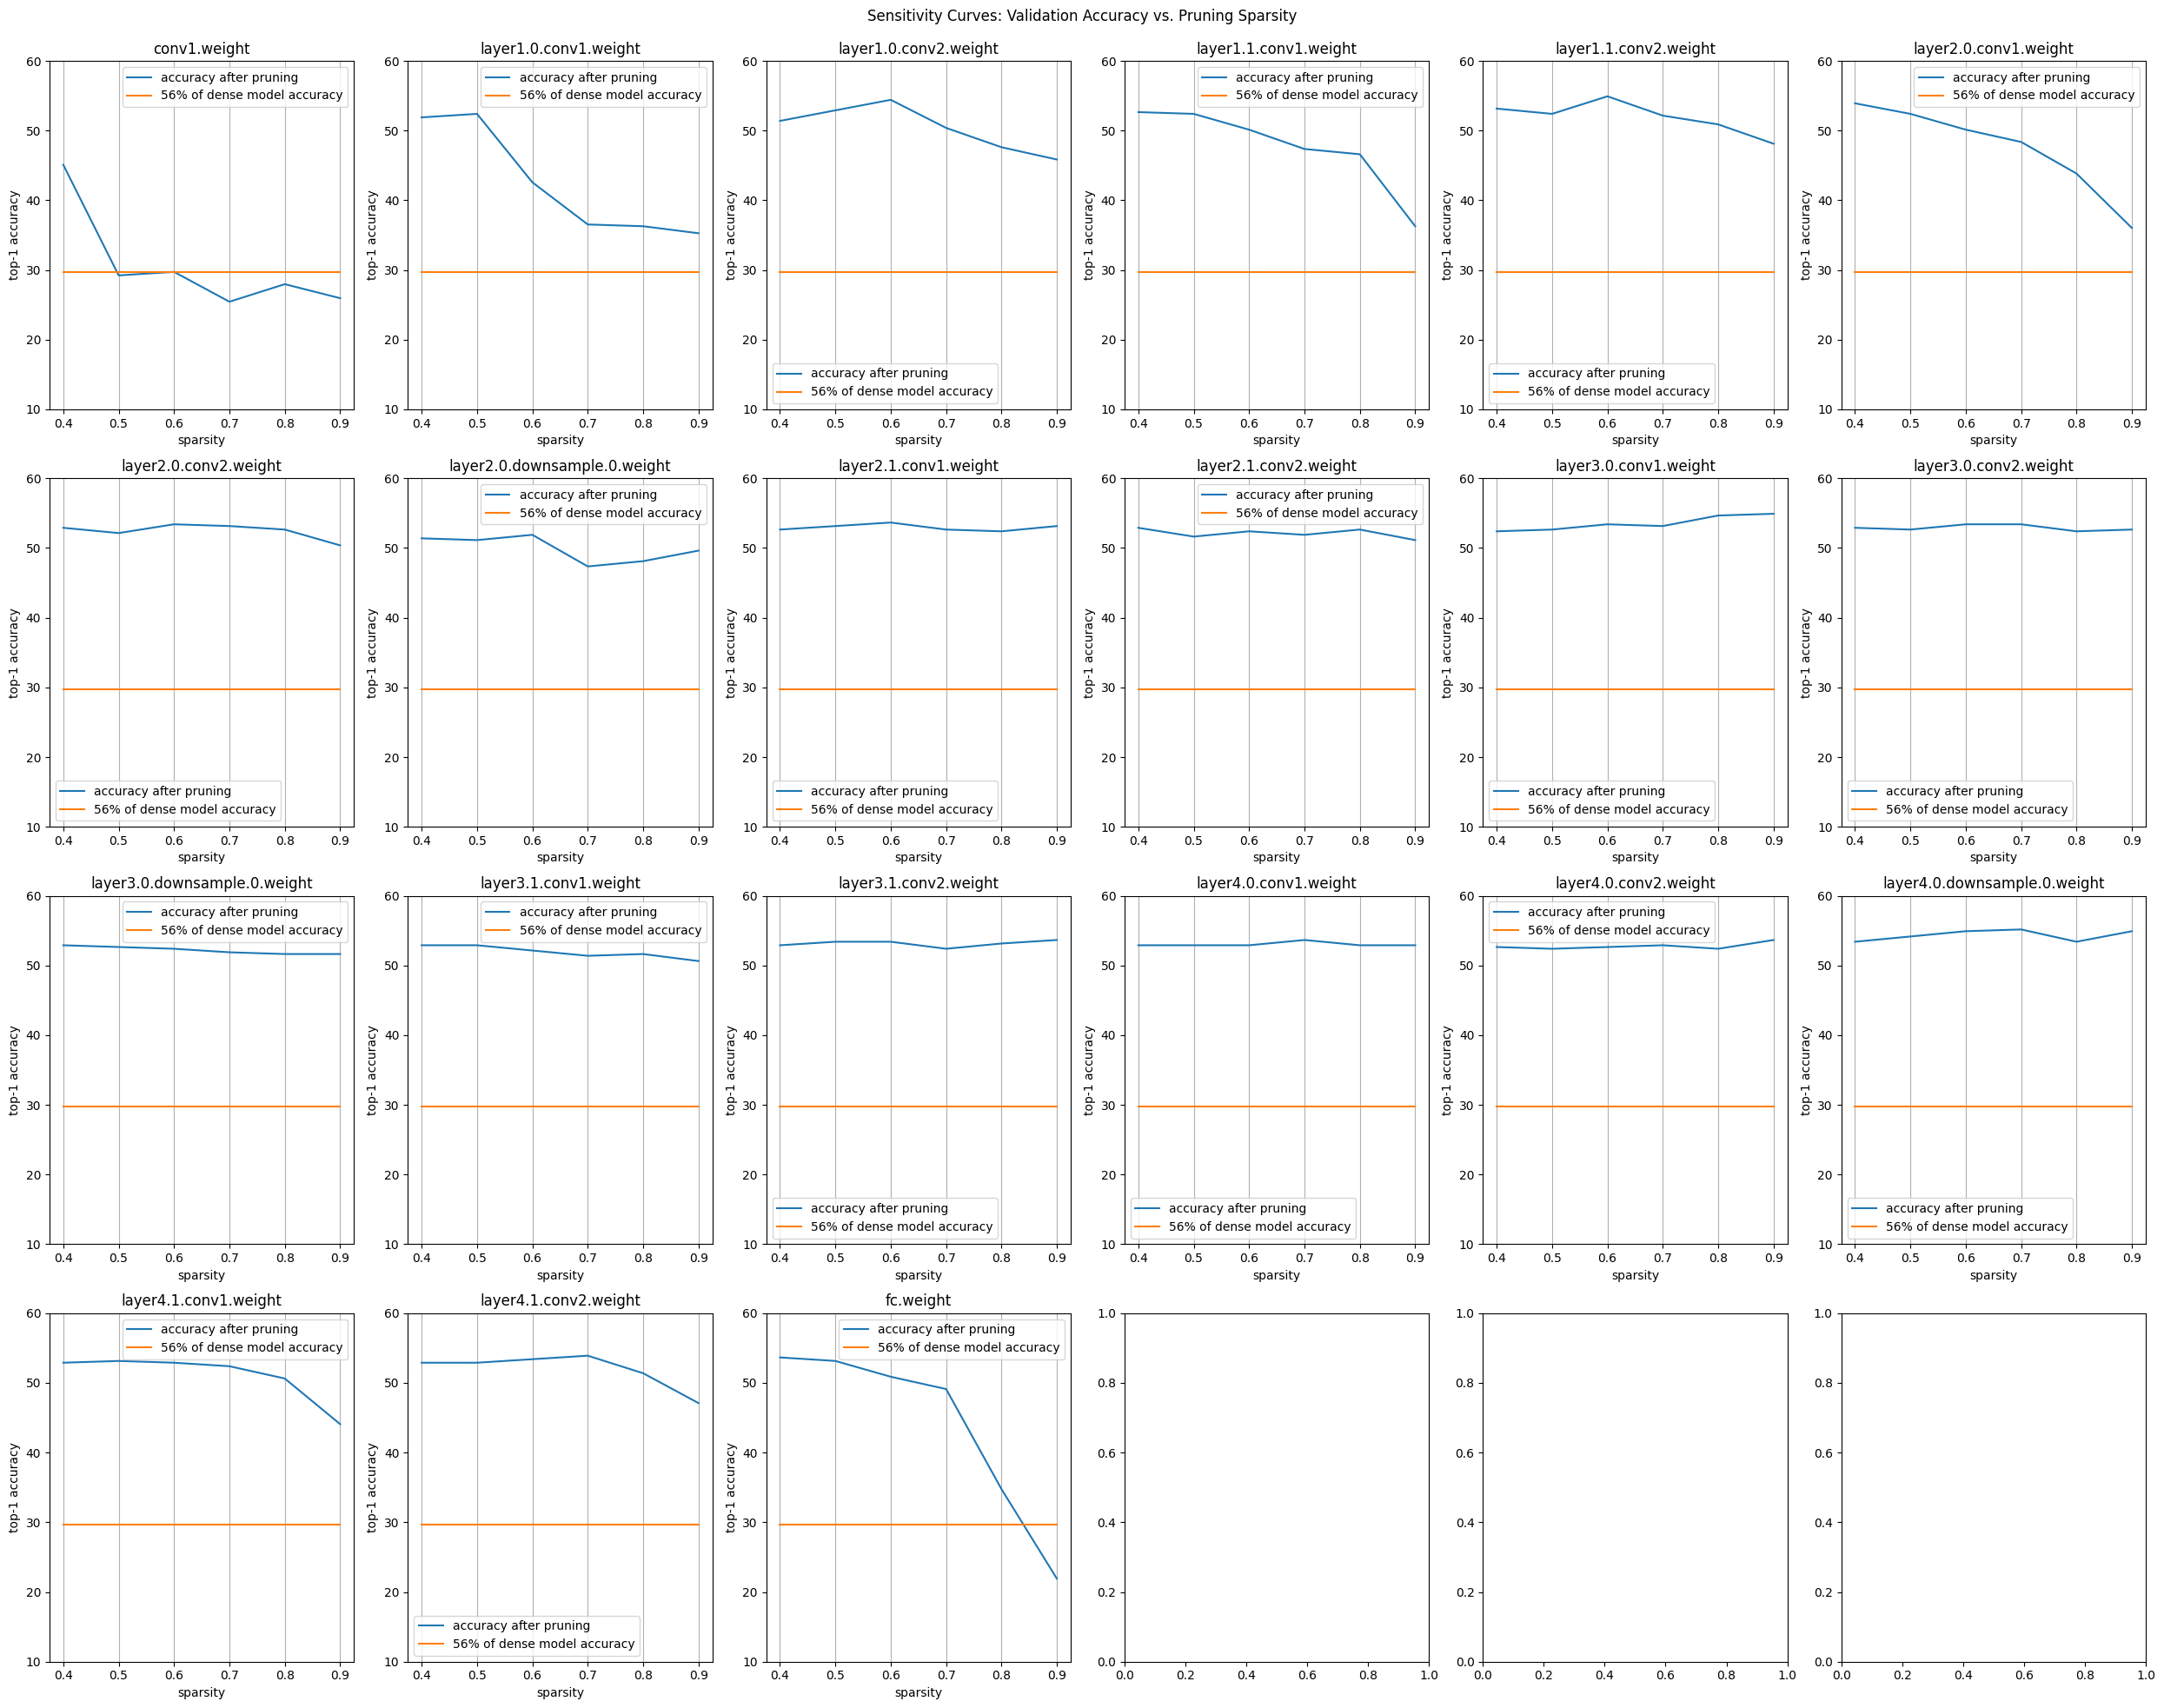

In [ ]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    num_plots = sum(1 for name, param in model.named_parameters() if param.dim() > 1)
    num_rows = int(math.ceil(num_plots / 6))  # Calculate rows for 5 columns
    fig, axes = plt.subplots(num_rows, 6, figsize=(25, 5 * num_rows))  # Adjust figsize
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_ylim(10, 60)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)  # Adjust top spacing
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

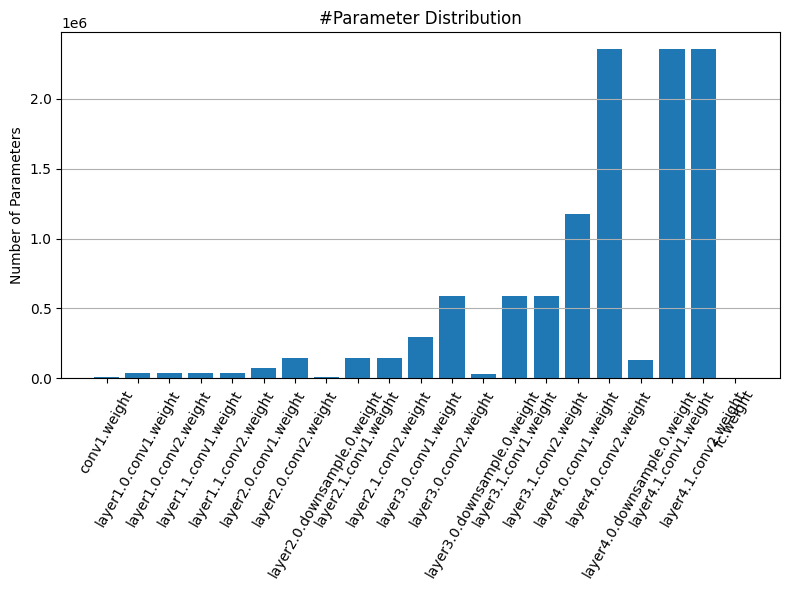

In [ ]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

### Define layer sparsity

In [ ]:
sparsity_dict = {}
for name, param in model.named_parameters():
    if param.dim() > 1:
        sparsity_dict[name] = 0.0

sparsity_dict

{'conv1.weight': 0.0,
 'layer1.0.conv1.weight': 0.0,
 'layer1.0.conv2.weight': 0.0,
 'layer1.1.conv1.weight': 0.0,
 'layer1.1.conv2.weight': 0.0,
 'layer2.0.conv1.weight': 0.0,
 'layer2.0.conv2.weight': 0.0,
 'layer2.0.downsample.0.weight': 0.0,
 'layer2.1.conv1.weight': 0.0,
 'layer2.1.conv2.weight': 0.0,
 'layer3.0.conv1.weight': 0.0,
 'layer3.0.conv2.weight': 0.0,
 'layer3.0.downsample.0.weight': 0.0,
 'layer3.1.conv1.weight': 0.0,
 'layer3.1.conv2.weight': 0.0,
 'layer4.0.conv1.weight': 0.0,
 'layer4.0.conv2.weight': 0.0,
 'layer4.0.downsample.0.weight': 0.0,
 'layer4.1.conv1.weight': 0.0,
 'layer4.1.conv2.weight': 0.0,
 'fc.weight': 0.0}

In [ ]:
sparsity_dict['layer1.0.conv1.weight'] = 0.5
sparsity_dict['layer1.0.conv2.weight'] = 0.6
sparsity_dict['layer1.1.conv1.weight'] = 0.5
sparsity_dict['layer1.1.conv2.weight'] = 0.7
sparsity_dict['layer2.0.conv1.weight'] = 0.5
sparsity_dict['layer2.0.conv2.weight'] = 0.9
sparsity_dict['layer2.1.conv1.weight'] = 0.9
sparsity_dict['layer2.1.conv2.weight'] = 0.9
sparsity_dict['layer3.0.conv1.weight'] = 0.9
sparsity_dict['layer3.0.conv2.weight'] = 0.9
sparsity_dict['layer3.1.conv1.weight'] = 0.9
sparsity_dict['layer3.1.conv2.weight'] = 0.9
sparsity_dict['layer4.0.conv1.weight'] = 0.9
sparsity_dict['layer4.0.conv2.weight'] = 0.9
sparsity_dict['layer4.1.conv1.weight'] = 0.8
sparsity_dict['layer4.1.conv2.weight'] = 0.8
sparsity_dict['layer2.0.downsample.0.weight'] = 0.5
sparsity_dict['layer3.0.downsample.0.weight'] = 0.9
sparsity_dict['layer4.0.downsample.0.weight'] = 0.9
sparsity_dict

{'conv1.weight': 0.0,
 'layer1.0.conv1.weight': 0.5,
 'layer1.0.conv2.weight': 0.6,
 'layer1.1.conv1.weight': 0.5,
 'layer1.1.conv2.weight': 0.7,
 'layer2.0.conv1.weight': 0.5,
 'layer2.0.conv2.weight': 0.9,
 'layer2.0.downsample.0.weight': 0.5,
 'layer2.1.conv1.weight': 0.9,
 'layer2.1.conv2.weight': 0.9,
 'layer3.0.conv1.weight': 0.9,
 'layer3.0.conv2.weight': 0.9,
 'layer3.0.downsample.0.weight': 0.9,
 'layer3.1.conv1.weight': 0.9,
 'layer3.1.conv2.weight': 0.9,
 'layer4.0.conv1.weight': 0.9,
 'layer4.0.conv2.weight': 0.9,
 'layer4.0.downsample.0.weight': 0.9,
 'layer4.1.conv1.weight': 0.8,
 'layer4.1.conv2.weight': 0.8,
 'fc.weight': 0.0}

In [ ]:
pruner = FineGrainedPruner(model, sparsity_dict)
# print(f'After pruning with sparsity dictionary')
# for name, sparsity in sparsity_dict.items():
#     print(f'  {name}: {sparsity:.2f}')
# print(f'The sparsity of each layer becomes')
# for name, param in model.named_parameters():
#     if name in sparsity_dict:
#         print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, val_loader)
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")


Sparse model has size=6.45 MiB = 15.13% of dense model size


[INFO] Evaluation - Accuracy: 29.22%
Sparse model has accuracy=29.22% before fintuning


## Fine Tuning

In [ ]:
num_finetune_epochs = 10
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()
save_path = "/content/drive/My Drive/resnet18_trashdetection/best_pruned_model_checkpoint_torchvision_resnet18.pth"

print(f'Finetuning Fine-grained Pruned Sparse Model')
print("-"*50)
train_losses, train_accuracies, val_losses, val_accuracies = train(
    model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    save_path=save_path,
    patience=patience,
    callbacks=[lambda: pruner.apply(model)] # apply pruning at the end of each training loop to keep model sparse
)

Finetuning Fine-grained Pruned Sparse Model
--------------------------------------------------


[INFO] Epoch 1/10 | Train Loss: 1.6625 | Train Accuracy: 40.50% | Validation Loss: 1.5186 | Validation Accuracy: 49.87%
[INFO] Checkpoint saved at epoch 1 with validation accuracy: 49.87%


[INFO] Epoch 2/10 | Train Loss: 1.6028 | Train Accuracy: 43.05% | Validation Loss: 1.5648 | Validation Accuracy: 51.64%
[INFO] Checkpoint saved at epoch 2 with validation accuracy: 51.64%


[INFO] Epoch 3/10 | Train Loss: 1.6644 | Train Accuracy: 42.89% | Validation Loss: 1.5679 | Validation Accuracy: 50.63%


[INFO] Epoch 4/10 | Train Loss: 1.6498 | Train Accuracy: 45.67% | Validation Loss: 2.6063 | Validation Accuracy: 31.23%


[INFO] Epoch 5/10 | Train Loss: 1.4978 | Train Accuracy: 46.80% | Validation Loss: 1.6928 | Validation Accuracy: 45.34%


[INFO] Epoch 6/10 | Train Loss: 1.5562 | Train Accuracy: 46.67% | Validation Loss: 3.4541 | Validation Accuracy: 31.23%


[INFO] Epoch 7/10 | Train Loss: 1.6684 | Train Accuracy: 45.22% | Validation Loss: 2.4003 | Validation Accuracy: 41.56%
[INFO] Early stopping triggered. No improvement for 5 epochs.


### Load model from drive

In [ ]:
# # load best sparsed model
# save_path = "/content/drive/My Drive/resnet18_trashdetection/best_pruned_model_checkpoint_torchvision_resnet18.pth"
# checkpoint = torch.load(save_path)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
# epoch = checkpoint['epoch']
# best_accuracy = checkpoint['best_accuracy']

In [ ]:
from torchvision import models, transforms
import torch.nn as nn
import torch

def recover_sparsed_model():
  model = models.resnet18(pretrained=False)
  model.fc = nn.Linear(model.fc.in_features, 8)
  save_path = "/content/drive/My Drive/resnet18_trashdetection/best_pruned_model_checkpoint_torchvision_resnet18.pth"
  checkpoint = torch.load(save_path)
  model.load_state_dict(checkpoint['model_state_dict'])
  return model
pruned_model = recover_sparsed_model()

In [ ]:
# save model on local
torch.save(model.state_dict(), 'pruned_model/resnet_18_pruned.pth')

In [ ]:
get_model_size(model, count_nonzero_only=True)/MiB

tensor(6.4522, device='cuda:0')

### Evaluate fine tuned pruned model

In [ ]:
print(f"After pruning & fine-tuning...")
sparse_model_acc = evaluate(model, val_loader)
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"[INFO] Accuracy = {sparse_model_acc:.4f}%")
print(f"[INFO] Model size = {sparse_model_size/MiB:.4f} MiB")

After pruning & fine-tuning...


[INFO] Evaluation - Accuracy: 51.64%
[INFO] Accuracy = 51.6373%
[INFO] Model size = 6.4522 MiB


In [ ]:
from torchvision import transforms
import numpy as np
import cv2
# Inference on single image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def predict_image(model, image_path, transform, class_names):
    model.eval()

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = transform(image)
    # image = augmented['image']
    # image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
    image = image.unsqueeze(0).to(device)

    outputs = model(image)
    _, predicted = outputs.max(1)
    print(predicted)
    print(f"Predicted Class: {class_names[predicted.item()]}")
class_names = ["Garbage", "Cardboard", "Garbage", "Glass", "Metal", "Paper", "Plastic", "Trash"]

predict_image(model, '/content/data/test/cardboard123_jpg.rf.7d247c9e6fc6eb72606d3a11acb5c455.jpg', get_transform(train=False), class_names)


tensor([1], device='cuda:0')
Predicted Class: Cardboard


### Push sparse model to HF

In [ ]:
from huggingface_hub import create_repo, upload_folder
import os

# Replace with your actual repository name
repo_name = "dmedhi/restnet-18-pruned-garbage-classification"

# Create the repository on the Hub if it doesn't exist
try:
    create_repo(repo_id=repo_name, exist_ok=True)
except Exception as e:
    print(f"Error creating or accessing repository: {e}")

# Define the path to your local model files
local_model_path = "./pruned_model"  # Adjust this path

try:
    upload_folder(
        repo_id=repo_name,
        folder_path=local_model_path,
        commit_message="Add model files and configurations"
    )
    print(f"Successfully uploaded to {repo_name}")
except Exception as e:
    print(f"Error uploading files: {e}")

Successfully uploaded to dmedhi/restnet-18-pruned-garbage-classification


## Inference Comparison

In [ ]:
get_model_size(model, count_nonzero_only=True)/MiB

tensor(42.6324, device='cuda:0')

## Quantization

### F32 model accuracy

In [ ]:
recover_sparsed_model()
fp32_model_accuracy = evaluate(model, val_loader)
fp32_model_size = get_model_size(model, count_nonzero_only=True)
print(f"fp32 model has accuracy={fp32_model_accuracy:.2f}%")
print(f"fp32 model has size={fp32_model_size/MiB:.2f} MiB")

[INFO] Evaluation - Accuracy: 51.64%
fp32 model has accuracy=51.64%
fp32 model has size=6.45 MiB


### K-Means quantization

In [ ]:
! pip install -q fast-pytorch-kmeans 1>/dev/null

In [ ]:
from collections import namedtuple
Codebook = namedtuple('Codebook', ['centroids', 'labels'])


In [ ]:
from fast_pytorch_kmeans import KMeans

def k_means_quantize(fp32_tensor: torch.Tensor, bitwidth=4, codebook=None):
    """
    quantize tensor using k-means clustering
    :param fp32_tensor:
    :param bitwidth: [int] quantization bit width, default=4
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
    :return:
        [Codebook = (centroids, labels)]
            centroids: [torch.(cuda.)FloatTensor] the cluster centroids
            labels: [torch.(cuda.)LongTensor] cluster label tensor
    """
    if codebook is None:
        n_clusters = 2**bitwidth
        kmeans = KMeans(n_clusters=n_clusters, mode='euclidean', verbose=0)
        labels = kmeans.fit_predict(fp32_tensor.view(-1, 1)).to(torch.long)

        centroids = kmeans.centroids.to(torch.float).view(-1)
        codebook = Codebook(centroids, labels)
    quantized_tensor = codebook.centroids[codebook.labels]
    fp32_tensor.set_(quantized_tensor.view_as(fp32_tensor))
    return codebook

In [ ]:
from torch.nn import parameter
class KMeansQuantizer:
    def __init__(self, model : nn.Module, bitwidth=4):
        self.codebook = KMeansQuantizer.quantize(model, bitwidth)

    @torch.no_grad()
    def apply(self, model, update_centroids):
        for name, param in model.named_parameters():
            if name in self.codebook:
                if update_centroids:
                    update_codebook(param, codebook=self.codebook[name])
                self.codebook[name] = k_means_quantize(
                    param, codebook=self.codebook[name])

    @staticmethod
    @torch.no_grad()
    def quantize(model: nn.Module, bitwidth=4):
        codebook = dict()
        if isinstance(bitwidth, dict):
            for name, param in model.named_parameters():
                if name in bitwidth:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth[name])
        else:
            for name, param in model.named_parameters():
                # print(f"{name=}: {param.shape}")
                # only quantize weight, not bias
                if param.dim() > 1:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth)
        return codebook

In [ ]:
print('Note that the storage for codebooks is ignored when calculating the model size.')
quantizers = dict()
for bitwidth in [8, 4, 2]:
    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer = KMeansQuantizer(model, bitwidth)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, val_loader)
    print(f"    {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}%")
    quantizers[bitwidth] = quantizer

Note that the storage for codebooks is ignored when calculating the model size.
k-means quantizing model into 8 bits
    8-bit k-means quantized model has size=10.66 MiB


[INFO] Evaluation - Accuracy: 51.39%
    8-bit k-means quantized model has accuracy=51.39%
k-means quantizing model into 4 bits
    4-bit k-means quantized model has size=5.33 MiB


[INFO] Evaluation - Accuracy: 29.22%
    4-bit k-means quantized model has accuracy=29.22%
k-means quantizing model into 2 bits
    2-bit k-means quantized model has size=2.67 MiB


[INFO] Evaluation - Accuracy: 17.38%
    2-bit k-means quantized model has accuracy=17.38%


### Fine-tuning quantized model

In [ ]:
# update centroids for each iterations
def update_codebook(fp32_tensor: torch.Tensor, codebook: Codebook):
    """
    update the centroids in the codebook using updated fp32_tensor
    :param fp32_tensor: [torch.(cuda.)Tensor]
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
    """
    n_clusters = codebook.centroids.numel()
    fp32_tensor = fp32_tensor.view(-1)
    for k in range(n_clusters):
        codebook.centroids[k] = torch.mean(fp32_tensor[codebook.labels==k])


In [ ]:
accuracy_drop_threshold = 0.5
quantizers_before_finetune = copy.deepcopy(quantizers)
quantizers_after_finetune = quantizers

for bitwidth in [8, 4, 2]:
    recover_sparsed_model()
    quantizer = quantizers[bitwidth]
    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer.apply(model, update_centroids=False)
    quantized_model_size = get_model_size(model, bitwidth, count_nonzero_only=True)
    print(f"[INFO] {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, val_loader)
    print(f"[INFO] {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}% before quantization-aware training ")

    accuracy_drop = fp32_model_accuracy - quantized_model_accuracy
    save_path = f"/content/drive/My Drive/resnet18_trashdetection/best_pruned_{bitwidth}bit_model_checkpoint_torchvision_resnet18.pth"
    if accuracy_drop > accuracy_drop_threshold:
        print(f"[INFO] Quantization-aware training due to accuracy drop={accuracy_drop:.2f}% is larger than threshold={accuracy_drop_threshold:.2f}%")
        num_finetune_epochs = 5
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
        criterion = nn.CrossEntropyLoss()
        best_accuracy = 0
        epoch = num_finetune_epochs

        while accuracy_drop > accuracy_drop_threshold and epoch > 0:
          train_losses, train_accuracies, val_losses, val_accuracies = train(
              model,
              train_dataloader=train_loader,
              val_dataloader=val_loader,
              criterion=criterion,
              optimizer=optimizer,
              scheduler=scheduler,
              num_epochs=epoch,
              save_path=save_path,
              patience=5,
              callbacks=[lambda: quantizer.apply(model, update_centroids=True)]
          )
          model_accuracy = evaluate(model, val_loader)
          is_best = model_accuracy > best_accuracy
          best_accuracy = max(model_accuracy, best_accuracy)
          print(f'[INFO] Epoch {num_finetune_epochs-epoch} Accuracy {model_accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')
          accuracy_drop = fp32_model_accuracy - best_accuracy
          epoch -= 1

    else:
        print(f"[INFO] No need for quantization-aware training since accuracy drop={accuracy_drop:.2f}% is smaller than threshold={accuracy_drop_threshold:.2f}%")

k-means quantizing model into 8 bits
[INFO] 8-bit k-means quantized model has size=5.21 MiB


[INFO] Evaluation - Accuracy: 51.39%
[INFO] 8-bit k-means quantized model has accuracy=51.39% before quantization-aware training 
[INFO] No need for quantization-aware training since accuracy drop=0.25% is smaller than threshold=0.50%
k-means quantizing model into 4 bits
[INFO] 4-bit k-means quantized model has size=5.33 MiB


[INFO] Evaluation - Accuracy: 29.47%
[INFO] 4-bit k-means quantized model has accuracy=29.47% before quantization-aware training 
[INFO] Quantization-aware training due to accuracy drop=22.17% is larger than threshold=0.50%


[INFO] Epoch 1/1 | Train Loss: 1.6506 | Train Accuracy: 40.11% | Validation Loss: 1.5770 | Validation Accuracy: 48.61%
[INFO] Checkpoint saved at epoch 1 with validation accuracy: 48.61%


[INFO] Evaluation - Accuracy: 48.61%
[INFO] Epoch 0 Accuracy 48.61% / Best Accuracy: 48.61%
k-means quantizing model into 2 bits
[INFO] 2-bit k-means quantized model has size=2.65 MiB


[INFO] Evaluation - Accuracy: 17.38%
[INFO] 2-bit k-means quantized model has accuracy=17.38% before quantization-aware training 
[INFO] Quantization-aware training due to accuracy drop=34.26% is larger than threshold=0.50%


[INFO] Epoch 1/1 | Train Loss: 1.9881 | Train Accuracy: 21.43% | Validation Loss: 1.8017 | Validation Accuracy: 31.99%
[INFO] Checkpoint saved at epoch 1 with validation accuracy: 31.99%


[INFO] Evaluation - Accuracy: 31.99%
[INFO] Epoch 0 Accuracy 31.99% / Best Accuracy: 31.99%


2bit quantization fine-tuning

In [ ]:
quantizers_before_finetune = copy.deepcopy(quantizers)
quantizers_after_finetune = quantizers
bitwidth = 2

print(f"Recover sparse model")
recover_sparsed_model()
quantizer = quantizers[bitwidth]

print(f'k-means quantizing model into {bitwidth} bits')
quantizer.apply(model, update_centroids=False)
quantized_model_size = get_model_size(model, bitwidth, count_nonzero_only=True)
print(f"[INFO] {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
quantized_model_accuracy = evaluate(model, val_loader)
print(f"[INFO] {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}% before quantization-aware training ")

accuracy_drop = fp32_model_accuracy - quantized_model_accuracy
save_path = f"/content/drive/My Drive/resnet18_trashdetection/best_pruned_{bitwidth}bit_model_checkpoint_torchvision_resnet18.pth"
print(f"[INFO] Quantization-aware training due to accuracy drop={accuracy_drop:.2f}% is larger than threshold={accuracy_drop_threshold:.2f}%")

num_finetune_epochs = 50
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()
best_accuracy = 0
epoch = num_finetune_epochs

print(f"[INFO] Fine-tuning quantized model for {epoch} epochs")
train_losses, train_accuracies, val_losses, val_accuracies = train(
    model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=epoch,
    save_path=save_path,
    patience=10,
    callbacks=[lambda: quantizer.apply(model, update_centroids=True)]
)


Recover sparse model
k-means quantizing model into 2 bits
[INFO] 2-bit k-means quantized model has size=2.67 MiB


[INFO] Evaluation - Accuracy: 29.22%
[INFO] 2-bit k-means quantized model has accuracy=29.22% before quantization-aware training 
[INFO] Quantization-aware training due to accuracy drop=22.42% is larger than threshold=0.50%
[INFO] Fine-tuning quantized model for 50 epochs


[INFO] Epoch 1/50 | Train Loss: 1.8426 | Train Accuracy: 25.50% | Validation Loss: 2.1186 | Validation Accuracy: 18.64%
[INFO] Checkpoint saved at epoch 1 with validation accuracy: 18.64%


[INFO] Epoch 2/50 | Train Loss: 1.8405 | Train Accuracy: 22.75% | Validation Loss: 1.8276 | Validation Accuracy: 23.43%
[INFO] Checkpoint saved at epoch 2 with validation accuracy: 23.43%


[INFO] Epoch 3/50 | Train Loss: 1.8130 | Train Accuracy: 25.37% | Validation Loss: 1.9507 | Validation Accuracy: 19.14%


[INFO] Epoch 4/50 | Train Loss: 1.8433 | Train Accuracy: 24.40% | Validation Loss: 1.7700 | Validation Accuracy: 33.50%
[INFO] Checkpoint saved at epoch 4 with validation accuracy: 33.50%


[INFO] Epoch 5/50 | Train Loss: 1.8070 | Train Accuracy: 27.83% | Validation Loss: 1.7473 | Validation Accuracy: 34.26%
[INFO] Checkpoint saved at epoch 5 with validation accuracy: 34.26%


[INFO] Epoch 6/50 | Train Loss: 1.7823 | Train Accuracy: 29.77% | Validation Loss: 1.7227 | Validation Accuracy: 35.52%
[INFO] Checkpoint saved at epoch 6 with validation accuracy: 35.52%


[INFO] Epoch 7/50 | Train Loss: 1.7653 | Train Accuracy: 30.70% | Validation Loss: 1.7032 | Validation Accuracy: 35.26%


[INFO] Epoch 8/50 | Train Loss: 1.7478 | Train Accuracy: 31.45% | Validation Loss: 1.7089 | Validation Accuracy: 36.78%
[INFO] Checkpoint saved at epoch 8 with validation accuracy: 36.78%


[INFO] Epoch 9/50 | Train Loss: 1.7461 | Train Accuracy: 30.93% | Validation Loss: 1.7004 | Validation Accuracy: 36.02%


[INFO] Epoch 10/50 | Train Loss: 1.7472 | Train Accuracy: 31.22% | Validation Loss: 1.6977 | Validation Accuracy: 37.28%
[INFO] Checkpoint saved at epoch 10 with validation accuracy: 37.28%


[INFO] Epoch 11/50 | Train Loss: 1.7369 | Train Accuracy: 31.51% | Validation Loss: 1.6948 | Validation Accuracy: 38.29%
[INFO] Checkpoint saved at epoch 11 with validation accuracy: 38.29%


[INFO] Epoch 12/50 | Train Loss: 1.7193 | Train Accuracy: 33.03% | Validation Loss: 1.6778 | Validation Accuracy: 36.52%


[INFO] Epoch 13/50 | Train Loss: 1.7201 | Train Accuracy: 32.74% | Validation Loss: 1.6839 | Validation Accuracy: 36.27%


[INFO] Epoch 14/50 | Train Loss: 1.7151 | Train Accuracy: 32.74% | Validation Loss: 1.6686 | Validation Accuracy: 36.78%


[INFO] Epoch 15/50 | Train Loss: 1.7163 | Train Accuracy: 32.22% | Validation Loss: 1.6888 | Validation Accuracy: 36.78%


[INFO] Epoch 16/50 | Train Loss: 1.7103 | Train Accuracy: 32.77% | Validation Loss: 1.6625 | Validation Accuracy: 38.29%


[INFO] Epoch 17/50 | Train Loss: 1.7073 | Train Accuracy: 33.19% | Validation Loss: 1.6627 | Validation Accuracy: 38.29%


[INFO] Epoch 18/50 | Train Loss: 1.7010 | Train Accuracy: 33.26% | Validation Loss: 1.6705 | Validation Accuracy: 38.29%


[INFO] Epoch 19/50 | Train Loss: 1.7000 | Train Accuracy: 33.61% | Validation Loss: 1.6641 | Validation Accuracy: 37.78%


[INFO] Epoch 20/50 | Train Loss: 1.6982 | Train Accuracy: 33.26% | Validation Loss: 1.6537 | Validation Accuracy: 37.78%


[INFO] Epoch 21/50 | Train Loss: 1.6849 | Train Accuracy: 33.68% | Validation Loss: 1.6615 | Validation Accuracy: 37.03%
[INFO] Early stopping triggered. No improvement for 10 epochs.


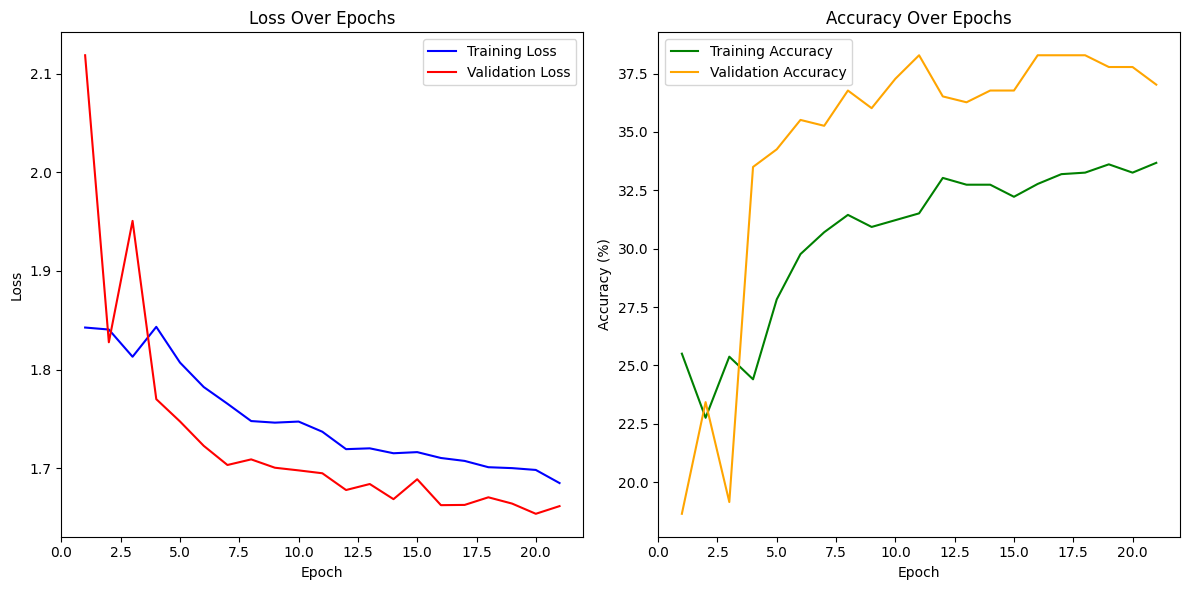

In [ ]:
plot_training_chart(train_losses, train_accuracies, val_losses, val_accuracies)

In [ ]:
from torchvision import models, transforms
import torch.nn as nn


def recover_quantized_model(bitwidth: int):
  model = models.resnet18()
  model.fc = nn.Linear(model.fc.in_features, 8)
  save_path = f"/content/drive/My Drive/resnet18_trashdetection/best_pruned_{bitwidth}bit_model_checkpoint_torchvision_resnet18.pth"
  checkpoint = torch.load(save_path)
  model.load_state_dict(checkpoint['model_state_dict'])
  return model

In [ ]:
model = recover_quantized_model(2)
quantized_model_size = get_model_size(model, 32)
print(f"[INFO] {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
model_accuracy = evaluate(model, val_loader)
print(f"{bitwidth}bit model has accuracy={model_accuracy:.2f}%")

[INFO] 2-bit k-means quantized model has size=42.65 MiB


[INFO] Evaluation - Accuracy: 38.29%
2bit model has accuracy=38.29%


In [ ]:
%%timeit
evaluate(model, val_loader)

[INFO] Evaluation - Accuracy: 38.29%


[INFO] Evaluation - Accuracy: 38.29%


[INFO] Evaluation - Accuracy: 38.29%


[INFO] Evaluation - Accuracy: 38.29%


[INFO] Evaluation - Accuracy: 38.29%


[INFO] Evaluation - Accuracy: 38.29%


[INFO] Evaluation - Accuracy: 38.29%


[INFO] Evaluation - Accuracy: 38.29%
2.58 s ± 457 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
from torchvision import transforms
import numpy as np
import cv2
# Inference on single image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def predict_image(model, image_path, transform, class_names):
    model.eval()

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = transform(image)
    # image = augmented['image']
    # image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
    image = image.unsqueeze(0).to(device)

    outputs = model(image)
    _, predicted = outputs.max(1)
    print(predicted)
    print(f"Predicted Class: {class_names[predicted.item()]}")
class_names = ["Garbage", "Cardboard", "Garbage", "Glass", "Metal", "Paper", "Plastic", "Trash"]

predict_image(model, '/content/data/test/cardboard123_jpg.rf.7d247c9e6fc6eb72606d3a11acb5c455.jpg', get_transform(train=False), class_names)


tensor([5], device='cuda:0')
Predicted Class: Paper


### Push model to HF

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import os
# Define the path to your local model files
local_model_path = "quantized_model"
os.makedirs(local_model_path, exist_ok=True)

torch.save(model.state_dict(), f'{local_model_path}/quantized_model.pth')

In [ ]:
from huggingface_hub import create_repo, upload_folder
import os

# Replace with your actual repository name
repo_name = "dmedhi/restnet-18-pruned-q-2-bit-garbage-classification"

try:
    create_repo(repo_id=repo_name, exist_ok=True)
except Exception as e:
    print(f"Error creating or accessing repository: {e}")

try:
    upload_folder(
        repo_id=repo_name,
        folder_path=local_model_path,
        commit_message="Add model files and configurations"
    )
    print(f"Successfully uploaded to {repo_name}")
except Exception as e:
    print(f"Error uploading files: {e}")

quantized_model.pth:   0%|          | 0.00/44.8M [00:00<?, ?B/s]

Successfully uploaded to dmedhi/restnet-18-pruned-q-2-bit-garbage-classification
